### Laboratorium 5 - zadania

Jeśli nie posiadasz jeszcze pakietu `skimage`, zainstaluj go poniższym poleceniem:

In [1]:
# !pip install scikit-image

In [2]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic
from skimage.util import img_as_float

#### Zadanie 1 (1.0 pkt | 1.0 pkt)

Dany jest obraz `hare`. Wykonaj dla niego segmentację przy użyciu algorytmu SLIC. Celem jest uzyskanie takich superpikseli, które zawierają tylko fragmenty zająca, lub tylko fragmenty trawy (a nie jedno i drugie naraz). Sprawdź zachowanie algorytmu dla różnej liczby superpikseli.

Zwróć uwagę, że wynikiem działania scikitowej implementacji SLIC (podobnie jak wielu innych algorytmów klasyfikacyjnych) jest obraz typu `np.int64` przyporządkowujący każdemu pikselowi obrazu wejściowego indeks superpiksela. Takiej reprezentacji oczekuje też funkcja `mark_boundaries`.

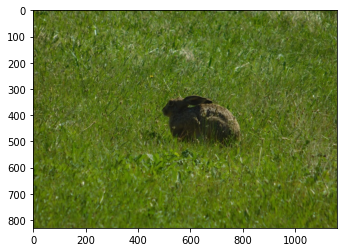

In [3]:
hare = cv2.imread('Zajac_kolor.jpg')[..., ::-1]
plt.imshow(hare);

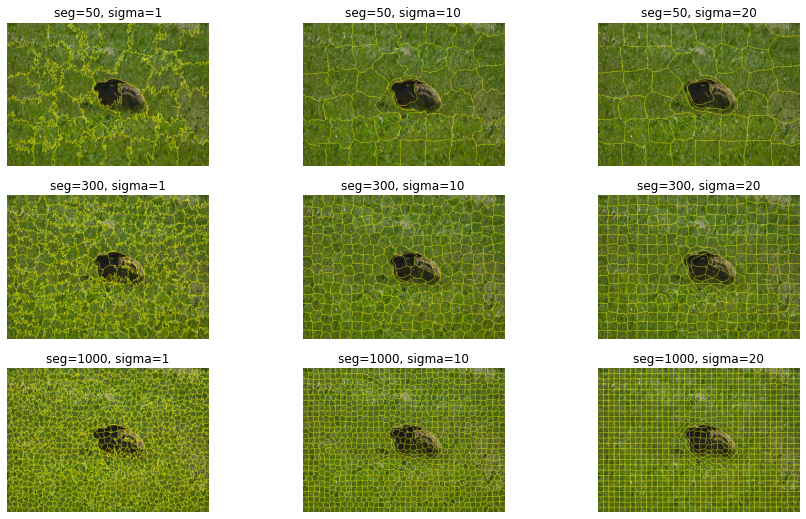

In [6]:
image = img_as_float(hare)

num_segments_lst = (50, 300, 1000)
sigma_lst = (1, 10, 20)

fig, axes = plt.subplots(len(num_segments_lst), len(sigma_lst), figsize=(len(num_segments_lst) * 5, len(sigma_lst) * 3))

for _axes, n_segments in zip(axes, num_segments_lst):
    for ax, sigma in zip(_axes, sigma_lst):
        segments = slic(image, n_segments = n_segments, sigma = sigma, start_label = 0)
        img_tmp = mark_boundaries(image, segments)
        ax.imshow(img_tmp)
        ax.set(title=f"seg={n_segments}, sigma={sigma}")
        ax.axis("off");

In [7]:
segments = slic(image, n_segments = 1000, sigma = 10, start_label = 0)

#### Zadanie 2 (2.0 pkt | 1.0 pkt)

Wykonaj post-processing segmentacji SLIC by uzyskać dwa jednorodne obszary: jeden zawierający wyłącznie zająca, drugi zawierający wyłącznie trawę. Wykorzystaj dowolny algorytm klasteryzacji (np. `cv2.kmeans`) używając *cech* superpikseli uzyskanych w zadaniu 1 jako danych wejściowych. Najprostszymi cechami, którymi można opisać superpiksele, są np. średnie wartości składowych barwy (pikseli, z których składa się superpiksel) - od nich zacznij. Zawsze możesz rozszerzyć rozwiązanie o bardziej wyrafinowane pomysły, jeśli starczy czasu.  
Zaprezentuj wyniki najlepiej za pomocą `mark_boundaries` albo po prostu wyświetlając maskę binarną.

---

NumPy pro-tip: aby uzyskać zbiór wszystkich pikseli obrazu o wartości np. 3 możesz użyć notacji: ```obraz==3```. Wynikiem jest macierz boolowska, której można używać jako selektor. Np. aby na obrazie `A` wyzerować wszystkie piksele, którym w obrazie `B` odpowiada wartość 5, możesz napisać: ```A[B==5] = 0```. Ten zapis jest **znacznie** szybszy niż manualne iterowanie po obrazach i sprawdzanie warunków if-ami.

Przykładowe użycie `cv2.kmeans` (więcej możesz poczytać np. [tutaj](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)):
```python
c, labels, centers = cv2.kmeans(
    data=data,  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=1, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
```

Funkcja ta zwraca krotkę, której najważniejszym komponentem jest ten drugi (tu: `labels`), tj. macierz o wymiarach Nx1, zawierająca indeks klastra przypisanego i-temu samplowi.

In [26]:
def get_mask(image, segments):
    superpixels_indices = np.unique(segments)
    superpixels_colors = np.empty((len(superpixels_indices), 3))
    for i, superpixel in enumerate(superpixels_indices):
        superpixels_colors[i] = image[segments == superpixel].mean(axis=0)

    superpixels_colors = superpixels_colors.astype(np.float32)

    image_colors = np.empty_like(image)
    for color, superpixel in zip(superpixels_colors, superpixels_indices):
        image_colors[segments == superpixel] = color
        
    c, labels, centers = cv2.kmeans(
        data=superpixels_colors,
        K=2,
        bestLabels=None,
        criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),
        attempts=1000, 
        flags=cv2.KMEANS_RANDOM_CENTERS,
    )
    
    image_mask = np.empty_like(segments)
    for label, superpixel in zip(labels, superpixels_indices):
        image_mask[segments == superpixel] = label
    
    return image_colors, image_mask, mark_boundaries(image, image_mask)

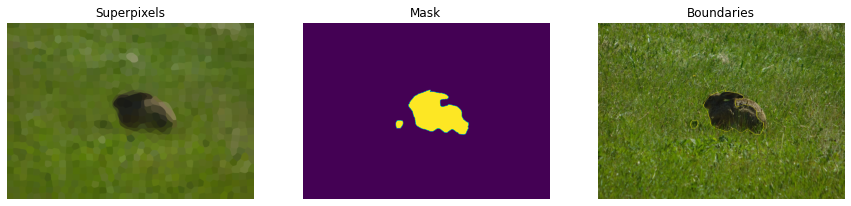

In [27]:
image_colors, image_mask, img_tmp = get_mask(image, segments)
    
fig, axes = plt.subplots(ncols=3, figsize=(15, 8))
    
axes[0].imshow(image_colors)
axes[0].axis('off');
axes[0].set(title="Superpixels")
axes[1].imshow(image_mask)
axes[1].axis('off');
axes[1].set(title="Mask")
axes[2].imshow(img_tmp)
axes[2].axis('off');
axes[2].set(title="Boundaries");

## Second iteration

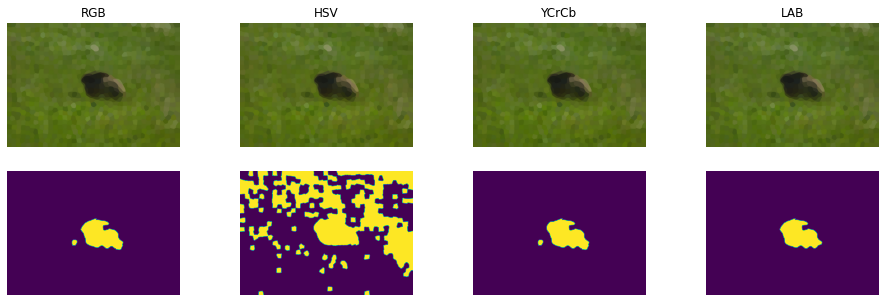

In [47]:
from tqdm import tqdm

new_image = (image.copy() * 255).astype(np.uint8)
images = dict(
    RGB = new_image,
    HSV = cv2.cvtColor(new_image, cv2.COLOR_RGB2HSV),
    YCrCb = cv2.cvtColor(new_image, cv2.COLOR_RGB2YCrCb),
    LAB = cv2.cvtColor(new_image, cv2.COLOR_RGB2LAB),
)

fig, axes = plt.subplots(nrows=2, ncols=len(images), figsize=(4 * len(images), 5))

for i, (name, img) in enumerate(images.items()):
    image_colors, image_mask, img_tmp = get_mask(img, segments)
    
    if name == 'HSV':
        image_colors = cv2.cvtColor(image_colors, cv2.COLOR_HSV2RGB)
    elif name == 'YCrCb':
        image_colors = cv2.cvtColor(image_colors, cv2.COLOR_YCrCb2RGB)
    elif name == 'LAB':
        image_colors = cv2.cvtColor(image_colors, cv2.COLOR_LAB2RGB)
    
    if image_mask.mean() > 0.5:
        image_mask = np.abs(image_mask - 1)
    
    axes[0, i].imshow(image_colors)
    axes[0, i].axis('off');
    axes[0, i].set(title=name)
    
    axes[1, i].imshow(image_mask)
    axes[1, i].axis('off');
#     axes[1, i].set(title=name)